In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange

from finetune.regression.biomasters_datamodule import BioMastersDataModule
from finetune.regression.biomasters_model import BioMastersClassifier

### Define paths and parameters

In [3]:
BIOMASTERS_CHECKPOINT_PATH = (
    "../../checkpoints/regression/biomasters_epoch-30_val-score-39.064.ckpt"
)
CLAY_CHECKPOINT_PATH = (
    "../../checkpoints/clay-v1.5.ckpt"
)
METADATA_PATH = "../../configs/metadata.yaml"

TRAIN_CHIP_DIR = "../../data/biomasters/train_cube/"
TRAIN_LABEL_DIR = "../../data/biomasters/train_agbm/"
VAL_CHIP_DIR = "../../data/biomasters/test_cube/"
VAL_LABEL_DIR = "../../data/biomasters/test_agbm/"

BATCH_SIZE = 32
NUM_WORKERS = 1

### Model Loading

In [4]:
def get_model(biomasters_checkpoint_path, clay_checkpoint_path, metadata_path):
    model = BioMastersClassifier.load_from_checkpoint(
        checkpoint_path=biomasters_checkpoint_path,
        metadata_path=metadata_path,
        ckpt_path=clay_checkpoint_path,
    )
    model.eval()
    return model

### Data Preparation

In [5]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
):
    dm = BioMastersDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
    )
    dm.setup(stage="fit")
    val_dl = iter(dm.val_dataloader())
    batch = next(val_dl)
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [6]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(256, 256), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [7]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means).reshape(1, -1, 1, 1)
    stds = np.array(stds).reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means
    return denormalized_images


def post_process(batch, outputs, metadata):
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()

    means = list(metadata["sentinel-2-l2a"].bands.mean.values())
    stds = list(metadata["sentinel-2-l2a"].bands.std.values())
    norm_pixels = denormalize_images(pixels, means, stds)

    images = rearrange(norm_pixels[:, :3, :, :], "b c h w -> b h w c")

    labels = np.clip(labels.squeeze(axis=1), 0, 400)
    outputs = np.clip(outputs.squeeze(axis=1), 0, 400)
    images = np.clip(images / 2000, 0, 1)

    return images, labels, outputs

### Plotting

In [8]:
def plot_predictions(images, labels, outputs):
    fig, axes = plt.subplots(12, 8, figsize=(12, 18))

    # Plot the images
    plot_data(axes, images, row_offset=0, title="Image")

    # Plot the actual segmentation maps
    plot_data(axes, labels, row_offset=1, title="Actual")

    # Plot the predicted segmentation maps
    plot_data(axes, outputs, row_offset=2, title="Pred")

    plt.tight_layout()
    plt.show()


def plot_data(ax, data, row_offset, title=None):
    for i, item in enumerate(data):
        row = row_offset + (i // 8) * 3
        col = i % 8
        ax[row, col].imshow(item, cmap="cividis")
        ax[row, col].axis("off")
        if title and col == 0:
            ax[row, col].set_title(title, rotation=0, fontsize=12)

In [9]:
# Load model
model = get_model(BIOMASTERS_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)

In [10]:
# Get data
batch, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    BATCH_SIZE,
    NUM_WORKERS,
)
# Move batch to GPU
batch = {k: v.to("cuda") for k, v in batch.items()}

Found 8631 chips to process for ../../data/biomasters/train_cube/
Found 2754 chips to process for ../../data/biomasters/test_cube/


In [11]:
# Run prediction
outputs = run_prediction(model, batch)

In [12]:
# Post-process the results
images, labels, outputs = post_process(batch, outputs, metadata)

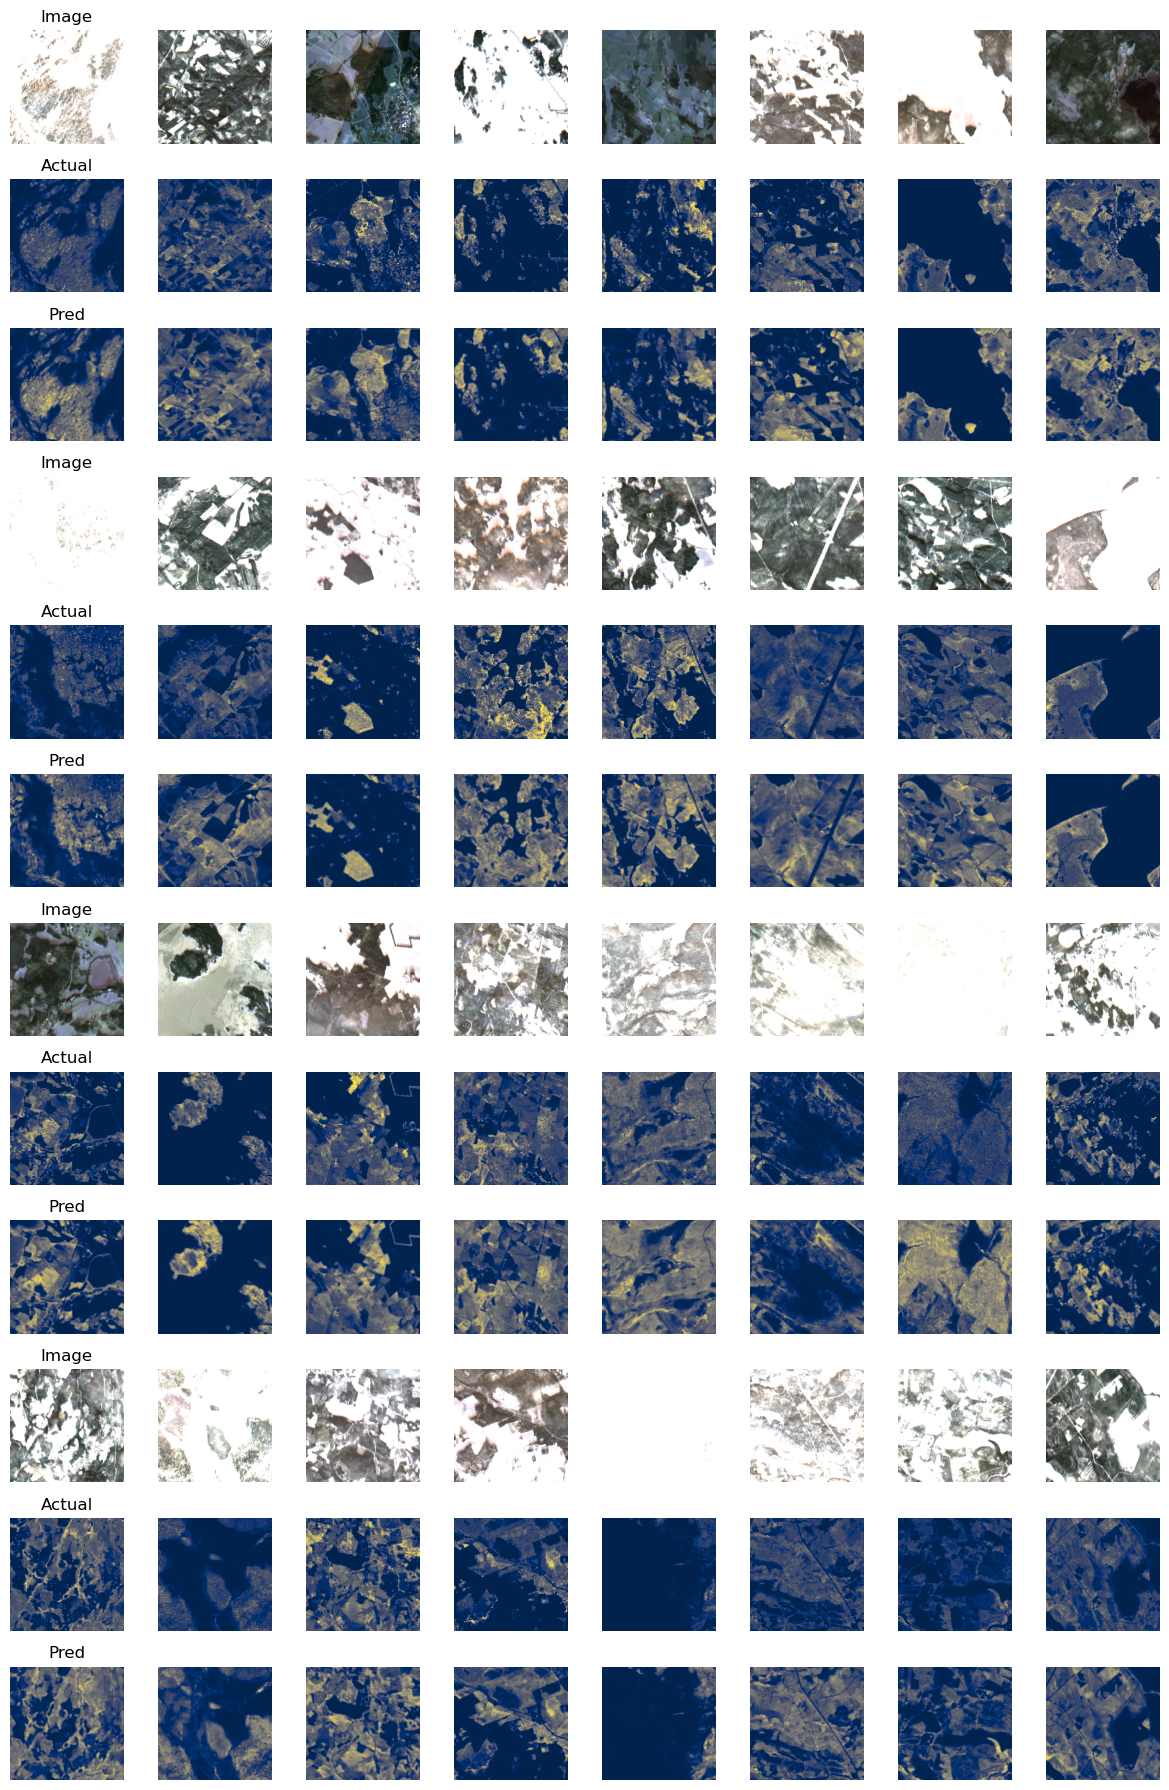

In [13]:
# Plot the predictions
plot_predictions(images, labels, outputs)